In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import norm, solve
from scipy.optimize import Bounds, minimize

%matplotlib inline
plt.rc('text', usetex=True)
plt.rcParams.update({'font.size': 15})

In [2]:
data_file = open('colombia.json',)
json_data = json.load(data_file)

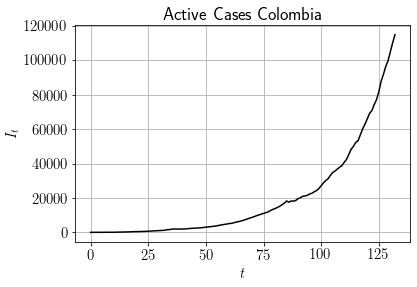

In [3]:
# Time series for Colombia
active_cases_co = json_data['co']['I']
plt.plot(active_cases_co, 'k')
plt.title('Active Cases Colombia')
plt.xlabel('$t$')
plt.ylabel('$I_t$')
plt.grid()
plt.show()

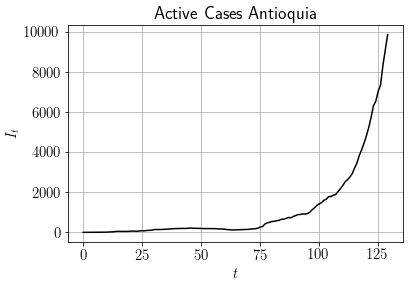

In [4]:
active_cases_an = json_data['co_05']['I']
plt.plot(active_cases_an, 'k')
plt.title('Active Cases Antioquia')
plt.xlabel('$t$')
plt.ylabel('$I_t$')
plt.grid()
plt.show()

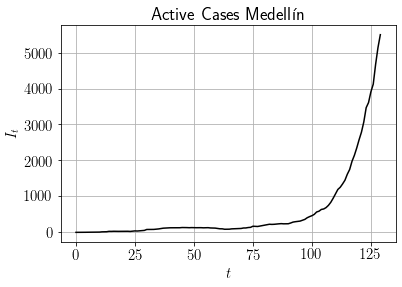

In [5]:
active_cases_me = json_data['co_05001']['I']
plt.plot(active_cases_me, 'k')
plt.title('Active Cases Medellín')
plt.xlabel('$t$')
plt.ylabel('$I_t$')
plt.grid()
plt.show()

# Estimate $R$ - ARMA LS

For data $\{I_{-2h},\ldots,I_{-1},I_{0},\ldots,I_t,I_{t+1}\}$

In [6]:
# time_series : 1D - np array (t+2,)
# h1          : int

def list2col(lst):
    return np.array(lst[::-1]).reshape((len(lst), 1))

def estimate_r(time_series, h1):
    if 2*h1 >= len(time_series) - 1:
        return None, None
    
    T = len(time_series) - 2*h1 - 2
    x = lambda t: list2col(time_series[(t + h1):(t + 2*h1 + 1)])
    v = lambda t: x(t - h1)
    
    V = np.zeros((h1 + 1, h1 + 1))
    Z = np.zeros((h1 + 1, h1 + 1))
    for s in range(T + 1):
        V += np.matmul(v(s), np.transpose(x(s+1)))
        Z += np.matmul(x(s), np.transpose(v(s)))
    
    A = np.matmul(np.transpose(V), np.linalg.inv(Z))
    
    betas = A[0, :]
    R = betas.sum()
    return R, A

# Estimate $R$ - AR Constrained LS

In [7]:
def estimate_r_opt(time_series, h, show=False):
    if 2*h >= len(time_series) - 1:
        return None
    
    T = len(time_series) - 2*h - 2
    x = lambda t: list2col(time_series[(t + h):(t + 2*h + 1)])
    
    A = []
    for s in range(h + 1):
        A.append(x(T-s))
    A = np.hstack(tuple(A))
    def of(R):
        aux = np.matmul(A, R.reshape((R.size, 1)))
        return np.power(norm(x(T+1) - aux), 2)
    
    init = np.zeros(h+1)
    bnds = Bounds([0 for s in range(h+1)], [np.inf for s in range(h+1)])
    sol = minimize(of, init, bounds=bnds)
    if show:
        print(sol)
    return sol.x.sum()

In [8]:
print(estimate_r_opt(active_cases_me, 14, show=True))

      fun: 70883.80973423523
 hess_inv: <15x15 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 8289.92633615,  7369.27759135, 11750.8097901 ,  5043.48427057,
        5615.93624298, 36778.75502035, 22287.61441074,  4480.58126494,
       24293.78946545,  3166.54186463, 10442.73813022,   812.95293057,
        5030.55925947, 18415.156228  , 14335.71742382])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1104
      nit: 39
   status: 0
  success: True
        x: array([0.47904896, 0.0297535 , 0.        , 0.18875614, 0.23678979,
       0.        , 0.        , 0.10219576, 0.        , 0.22949274,
       0.        , 0.28820988, 0.00109442, 0.        , 0.        ])
1.5553411884821988


In [9]:
print(estimate_r_opt(active_cases_co, 14, show=True))

      fun: 7328111.5642430615
 hess_inv: <15x15 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 6716894.54466105,  9942626.953125  , 11420831.45678043,
       13085990.86478353,  9786133.18875432, 11221990.6412065 ,
       10222570.22559643,  7489503.64068151,  9952221.34515643,
        9357008.80363584,  6122688.76284361,  5212670.19212246,
        1272491.64506793,  9418981.98798299, 13422415.21924734])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 704
      nit: 21
   status: 0
  success: True
        x: array([0.33294867, 0.14665989, 0.        , 0.        , 0.02434081,
       0.05585371, 0.11969839, 0.16403681, 0.03946406, 0.        ,
       0.03895249, 0.09747964, 0.24882647, 0.09222038, 0.        ])
1.3604813281877897


## Dynamics of $R$ w.r.t $h$ and $t^*$

In [10]:
def analyze_r(time_series, h=14, h0=2, title=''):
    Rsh = []
    Rst = []
    index = -1
    delta_h = 0
    first = False
    second = False
    while True:
        if len(time_series[:index]) < 2*h0 + 2:
            first = True
        if len(time_series) < 2*(h0 + delta_h) + 2:
            second = True
        if first or second:
            break
        if not first:
            Rst.append(estimate_r_opt(time_series[:index], h))
            index -= 1
        if not second:
            Rsh.append(estimate_r_opt(time_series, h0 + delta_h))
            delta_h += 1
        
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12, 5])
    ax1.plot(Rsh, 'k')
    ax1.set_xlabel('$h$')
    ax1.set_ylabel('$R_0$')
    
    ax2.plot(Rst, 'k')
    ax2.set_xlabel('$t^*$')
    ax2.set_ylabel('$R_0$')
    fig.suptitle(title)
    plt.show()
    
    return Rsh, Rst

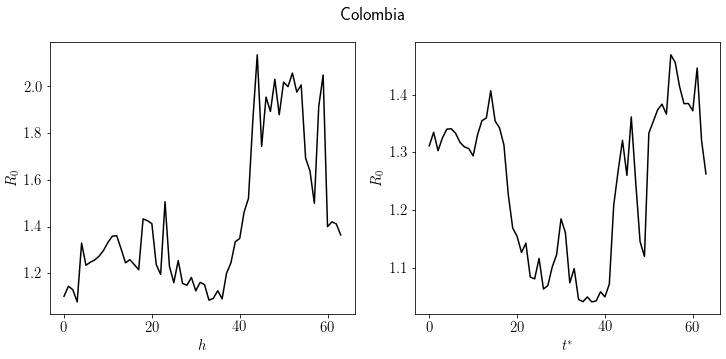

In [11]:
_, _ = analyze_r(active_cases_co, title='Colombia')

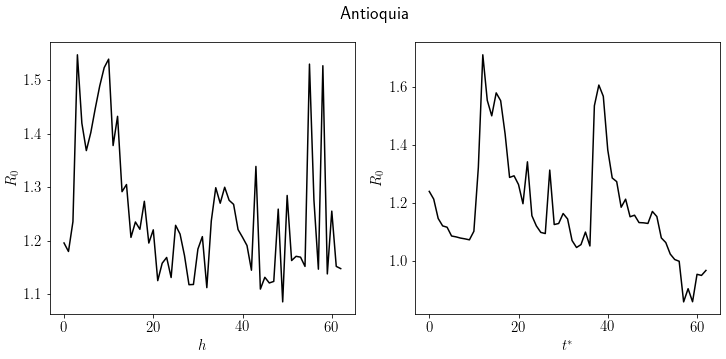

In [12]:
_, _ = analyze_r(active_cases_an, title='Antioquia')

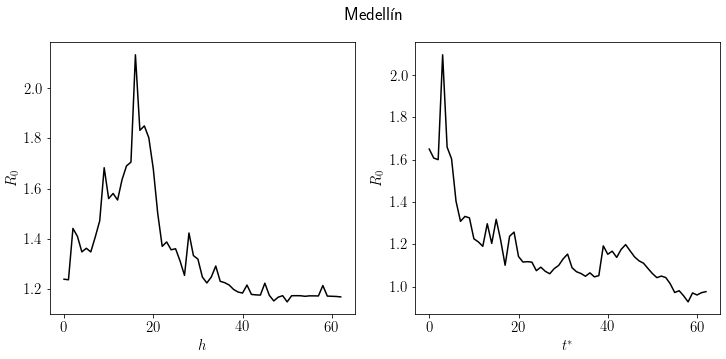

In [13]:
_, _ = analyze_r(active_cases_me, title='Medellín')

In [14]:
san_carlos = json_data['co_05649']['I']

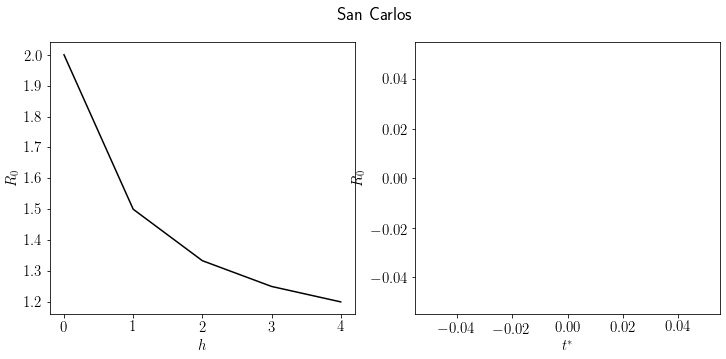

In [15]:
_, _ = analyze_r(san_carlos, title='San Carlos')

In [16]:
active_cases_bog = json_data['co_11']['I']

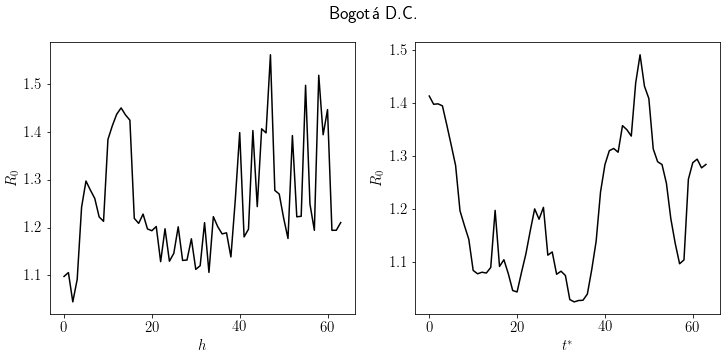

In [17]:
_, _ = analyze_r(active_cases_bog, title='Bogotá D.C.')

In [18]:
print(estimate_r_opt(active_cases_bog, 14, show=True))

      fun: 5666079.015753252
 hess_inv: <15x15 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2601515.31547308,  6662801.18748546, 10449783.22461247,
       12868640.4787004 , 12436361.33149266,  9136772.06262946,
        5662382.67347217,  3790197.80084491,  4265235.64383388,
        3850942.0119226 ,  5221720.13297677,  4594131.74539804,
        3778033.14477205,  3269487.99192905,  3405439.0154779 ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 240
      nit: 5
   status: 0
  success: True
        x: array([0.19330336, 0.14577886, 0.09912297, 0.06563762, 0.05921535,
       0.07950469, 0.10282355, 0.11203503, 0.10175953, 0.09736608,
       0.07772671, 0.07603799, 0.07695259, 0.07713472, 0.07182893])
1.4362279668891131
